In [1]:
import datetime
import time
import csv
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
import re
from IPython.display import Video
sys.path.insert(0, os.getcwd())

import plotter

## I. Population-based Search Strategies

- **Heuristic**. Examination of part of all the solutions, following known algorithm _(unlike Complete algorithms)._

- **Non-Deterministic**
    - Can escape local maxima due to randomness;
    - Due to stochasticity – different executions lead to different solutions;

<p align="center">
  <img src=IMG\Slide7.jpg>
</p>

## II. Evolutionary Algorithms refresher

* EAs exploit the ideas behind the Darwinian Theory of Evolution:
    * Genes are at the heart of all EAs – **genotype defines phenotype** (genotype = chromosomes = individual).
    * Individuals could be bit strings, real numbers, data structure, etc.

<p align="center">
  <img src=IMG/Slide8_3.jpg>
</p>

<p align="center">
  <img src=IMG/Slide8_2.jpg>
</p>

## Example: OneMax Problem

#### OneMax problem for 10-bit binary sequences:
* Maximize number of “1” in individuals of form: 1010101001;
* Fitness function: $$ℎ(𝑥)= \sum_{𝑖=1}^{10} 𝑥_𝑖 ; $$
* Initial probability model (uniform distribution): $$𝑝_0 (𝑥_𝑖=1)=0.5; ∀𝑖∈[1,10]; $$

#### In other words

<p align="center">
  <img src=IMG/Slide13.jpg>
</p>

* All the individuals compose the population

<p align="center">
  <img src=IMG/Slide14.jpg>
</p>

* We evaluate _goodness_ of each individual using _fitness function_:
$$ℎ(𝑥)= \sum_{𝑖=1}^{10} 𝑥_𝑖 ; $$

<p align="center">
  <img src=IMG/Slide15.jpg>
</p>

Several individuals could be selected as parents to generate the offspring:
* The best individuals – _elitist approach;_
* Random individuals – _lottery ticket approach;_

<p align="center">
  <img src=IMG/Slide16.jpg>
</p>

* Selected parents can create the offspring in cross-over operation.
* Offspring inherits chromosomes from both parents.
* The offspring can mutate (the chromosomes can spontaneously change).
* Finally, the offspring, which better fits the environment, survives.

<p align="center">
  <img src=IMG/Slide20.jpg>
</p>

<p align="center">
  <img src=IMG/Slide21.jpg>
</p>

<p align="center">
  <img src=IMG/Slide22.jpg>
</p>

## Evolutionary Algorithm Refreseher

<p align="center">
  <img src=IMG/Slide23.jpg>
</p>

## Evolutionary Algorithms - Coding Time!


<img src="https://media.giphy.com/media/13UZisxBxkjPwI/giphy.gif" width="1024" align="center">

### 1. Define the Individual (Chromosome)

In [2]:
class Chromosome:
 
    def __init__(self, genes, fitness): 
        self.Genes = genes
        self.Fitness = fitness 

### 2. Define all the EA methods

In [5]:
class EA:

    def __init__(self, parameters, get_fitness):
        self.alg_type = 'EA'
        self.gene_set = parameters['gene_set']
        self.length = parameters['length']
        self.pop_size = parameters['pop_size']
        self.ratio = parameters['selection_ratio']
        self.mutation = parameters['mutation']
        self.get_fitness = get_fitness
        self.pop = []
        self.num_selected = int(self.pop_size * self.ratio)
        self.start_time = None
        self.iteration = 0
        self.name = self.give_name()

    def give_name(self):
        name = '_'.join([self.alg_type, \
                      str(self.length), \
                      str(self.pop_size), \
                      str(self.ratio), \
                      str(self.mutation), \
                      str(int(time.time()))]) +\
                    '.csv'
        return name
        
    def generate_parent(self):
        genes = []
        while len(genes) < self.length:
            sample_size = min(self.length - len(genes), len(self.gene_set))
            genes.extend(random.sample(self.gene_set, sample_size))
        fitness = get_fitness(genes)
        return Chromosome(genes, fitness)

    def population(self):
        for i in range(self.pop_size):
            self.pop.append(self.generate_parent())

    def selection(self):
        self.pop.sort(key=lambda x: x.Fitness, reverse=True)
        self.pop = self.pop[:self.num_selected]

    def mutate(self, parent):
        child_genes = parent.Genes[:]
        index = random.randrange(0, len(parent.Genes))
        new_gene, alternate = random.sample(self.gene_set, 2)
        child_genes[index] = alternate \
            if new_gene == child_genes[index] \
            else new_gene
        fitness = self.get_fitness(child_genes)
        return Chromosome(child_genes, fitness)

    def crossover(self):
        u_distr = np.random.rand(self.length)
        res = []
        while len(res) < self.pop_size:
            index_1 = random.randrange(0, self.num_selected)
            index_2 = random.randrange(0, self.num_selected)
            p1 = np.array(self.pop[index_1].Genes)
            p2 = np.array(self.pop[index_2].Genes)
            ch_1 = []
            for j in range(len(u_distr)):
                if u_distr[j] >= 0.5:
                    ch_1.append(p1[j])
                else:
                    ch_1.append(p2[j])
            if self.mutation >= random.random():
                child = self.mutate(Chromosome(ch_1, ch_1.count(1)))
            else:
                child = Chromosome(ch_1, ch_1.count(1))
            res.append(child)

        return res

    def display(self, candidate):
        timeDiff = datetime.datetime.now() - self.start_time
        if len(candidate.Genes) > 30:
            print("{0}\t{1}...{2}\t{3:3.2f}\t{4}".format(
                'It_' + str(self.iteration),
                ''.join(map(str, candidate.Genes[:15])),
                ''.join(map(str, candidate.Genes[-15:])),
                candidate.Fitness,
                str(timeDiff)))
        else:
            print("{0}\t{1}\t{2:3.2f}\t{3}".format(
                'It_' + str(self.iteration),
                ''.join(map(str, candidate.Genes)),
                candidate.Fitness,
                str(timeDiff)))

        with open(self.name, mode='a') as file:
            header = ['iteration', 'best_ind', 'fitness', 'time']
            writer = csv.writer(file, delimiter=',')

            if os.path.getsize(self.name) == 0:
                writer.writerow(header)
                writer.writerow([self.iteration, candidate.Genes, candidate.Fitness, timeDiff])
            else:
                writer.writerow([self.iteration, candidate.Genes, candidate.Fitness, timeDiff])

    def get_best_ea(self, initial_pop):

        random.seed()
        self.start_time = datetime.datetime.now()
        
        if len(initial_pop) != 0:
            self.pop = initial_pop
        else:
            self.population()

        self.selection()
        best_parent = self.pop[0]
        self.display(best_parent)
        
        # Stopping criterion
        if best_parent.Fitness >= self.length:
            return best_parent
        
        # Searching the best individuals
        while True:
            self.iteration += 1
            self.pop = self.crossover()
            self.selection()
            best_child = self.pop[0]
            
            if best_parent.Fitness >= best_child.Fitness:
                continue

            self.display(best_child)
            
            # Stopping criterion
            if best_child.Fitness >= self.length:
                return best_child

            best_parent = best_child

    def check_params(self):
        temp = vars(self)
        # print('Enlist all the input parameters')
        for item in temp:
            print(item, ':', temp[item])

### 3. Evolutionary Algorithm Parameters

In [6]:
parameters = {'gene_set': [0, 1],
              'length': 10,
              'pop_size': 10,
              'selection_ratio': 0.5,
              'mutation': 0.01}

initial_population = []

def get_fitness(genes):
    return genes.count(1)

### 4. Initialize the population

In [7]:
ea = EA(parameters, get_fitness)
ea.population()

for individual in ea.pop:
    print("Genes: {}; Fitness: {};".format(individual.Genes, individual.Fitness))

Genes: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 1, 0, 0, 1, 0, 1]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]; Fitness: 5;
Genes: [1, 0, 1, 0, 1, 0, 1, 0, 0, 1]; Fitness: 5;
Genes: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 0, 1, 1, 0, 0, 1]; Fitness: 5;
Genes: [0, 1, 1, 0, 0, 1, 1, 0, 0, 1]; Fitness: 5;
Genes: [0, 1, 1, 0, 0, 1, 0, 1, 1, 0]; Fitness: 5;


### 5. Select the best individuals

In [8]:
ea.selection()

for individual in ea.pop:
    print("Genes: {}; Fitness: {};".format(individual.Genes, individual.Fitness))

Genes: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 1, 0, 0, 1, 0, 1]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]; Fitness: 5;


### 6. Perform crossover and mutation operation

In [9]:
ea.pop = ea.crossover()

for individual in ea.pop:
    print("Genes: {}; Fitness: {};".format(individual.Genes, individual.Fitness))

Genes: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]; Fitness: 4;
Genes: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 1, 0, 0, 1, 0, 1]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]; Fitness: 4;
Genes: [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]; Fitness: 5;
Genes: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]; Fitness: 5;
Genes: [1, 0, 1, 0, 0, 0, 0, 1, 0, 1]; Fitness: 4;


### 7. Let's make a loop from these operations

<p align="center">
  <img src=IMG/Slide24.jpg>
</p>

In [24]:
parameters = {'gene_set': [0, 1],
              'length': 10,
              'pop_size': 200,
              'selection_ratio': 0.5,
              'mutation': 0}

initial_population = []

def get_fitness(genes):
    return genes.count(12)

In [25]:
ea = EA(parameters, get_fitness)
ea.get_best_ea(initial_population)

It_0	0101010110	0.00	0:00:00.004525
It_1	1011010111	7.00	0:00:00.010023
It_2	1011101111	8.00	0:00:00.013444
It_3	0111111111	9.00	0:00:00.017999
It_5	1111111111	10.00	0:00:00.022674


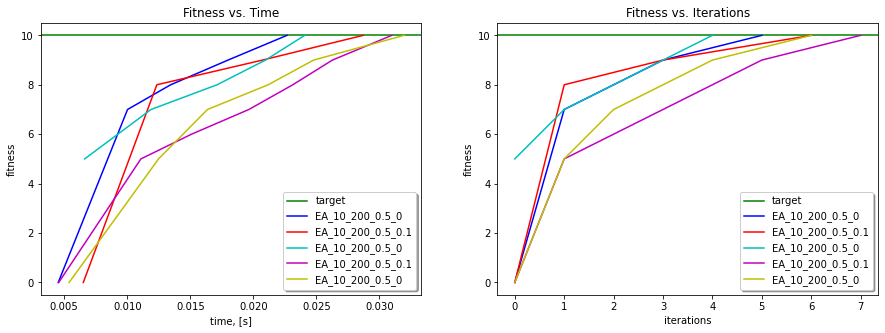

In [26]:
# PLOTTING THE RESULTS
plt_uno = plotter.Plotter()
plt_uno.fitness_vs_time(10) # specify the length of the string

In [ ]:
ALGORITHM_LENGTH_POP_RATIO_MUTATION

# Thank You!

# Q&A